In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        #self.fc1 = nn.Linear(28*28, 128)
        self.fc1 = nn.Linear(28*28, 1000)
        #self.fc2 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(1000, 1000)
        #self.fc3 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(1000, 10)
        if batchnorm:
            #self.bn = nn.BatchNorm1d(128)
            self.bn = nn.BatchNorm1d(1000)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
               
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
acc_train_m=[]
def train(epoch, models):
    train_size = len(train_loader.sampler)
    correct = [0]*len(models)
    for batch_idx, (data, target) in enumerate(train_loader):
        for i, model in enumerate(models): #model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()            
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
        correct_pct = [100. * c / train_size for c in correct]
        
        #([correct_pct[i] for i in range(len(models))])
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
        print(line + losses)
    
    acc_train_m.append(correct_pct)

In [5]:
#models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]
models = [Net(True, False)]

In [6]:
acc_test_m=[]
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    acc_test_m.append(correct_pct)
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)

In [7]:
for epoch in range(1, 101):
    for model in models:
        model.train()
    train(epoch, models)
    for model in models:
        model.eval()
    test(models, valid_loader)

Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.312860
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.162275
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.163655
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.276924
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.184385
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.196797
Test set:
0: Loss: 0.2559	Accuracy: 9268/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.147737
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.176621
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.034998
Train Epoch: 2 [30000/50000 (60%)]	Losses 0: 0.060784
Train Epoch: 2 [40000/50000 (80%)]	Losses 0: 0.013656
Train Epoch: 2 [50000/50000 (100%)]	Losses 0: 0.145089
Test set:
0: Loss: 0.1914	Accuracy: 9451/10000 (94%)

Train Epoch: 3 [0/50000 (0%)]	Losses 0: 0.107352
Train Epoch: 3 [10000/50000 (20%)]	Losses 0: 0.065697
Train Epoch: 3 [20000/50000 (40%)]	Losses 0: 0.082180
Train Epoch: 3 [30000/50000 (60%)]	Losses 0: 0.183318
Train Epoch: 3 [40000/50000 (80%)]	Losses

Train Epoch: 22 [40000/50000 (80%)]	Losses 0: 0.013129
Train Epoch: 22 [50000/50000 (100%)]	Losses 0: 0.000721
Test set:
0: Loss: 0.2408	Accuracy: 9402/10000 (94%)

Train Epoch: 23 [0/50000 (0%)]	Losses 0: 0.000532
Train Epoch: 23 [10000/50000 (20%)]	Losses 0: 0.000660
Train Epoch: 23 [20000/50000 (40%)]	Losses 0: 0.000417
Train Epoch: 23 [30000/50000 (60%)]	Losses 0: 0.013139
Train Epoch: 23 [40000/50000 (80%)]	Losses 0: 0.003220
Train Epoch: 23 [50000/50000 (100%)]	Losses 0: 0.007656
Test set:
0: Loss: 0.1663	Accuracy: 9598/10000 (95%)

Train Epoch: 24 [0/50000 (0%)]	Losses 0: 0.009057
Train Epoch: 24 [10000/50000 (20%)]	Losses 0: 0.005340
Train Epoch: 24 [20000/50000 (40%)]	Losses 0: 0.000041
Train Epoch: 24 [30000/50000 (60%)]	Losses 0: 0.002090
Train Epoch: 24 [40000/50000 (80%)]	Losses 0: 0.001114
Train Epoch: 24 [50000/50000 (100%)]	Losses 0: 0.000214
Test set:
0: Loss: 0.2678	Accuracy: 9369/10000 (93%)

Train Epoch: 25 [0/50000 (0%)]	Losses 0: 0.002882
Train Epoch: 25 [10000/50

Train Epoch: 44 [0/50000 (0%)]	Losses 0: 0.000433
Train Epoch: 44 [10000/50000 (20%)]	Losses 0: 0.000214
Train Epoch: 44 [20000/50000 (40%)]	Losses 0: 0.000034
Train Epoch: 44 [30000/50000 (60%)]	Losses 0: 0.008094
Train Epoch: 44 [40000/50000 (80%)]	Losses 0: 0.000489
Train Epoch: 44 [50000/50000 (100%)]	Losses 0: 0.001992
Test set:
0: Loss: 0.1390	Accuracy: 9729/10000 (97%)

Train Epoch: 45 [0/50000 (0%)]	Losses 0: 0.001663
Train Epoch: 45 [10000/50000 (20%)]	Losses 0: 0.000089
Train Epoch: 45 [20000/50000 (40%)]	Losses 0: 0.001794
Train Epoch: 45 [30000/50000 (60%)]	Losses 0: 0.024265
Train Epoch: 45 [40000/50000 (80%)]	Losses 0: 0.001026
Train Epoch: 45 [50000/50000 (100%)]	Losses 0: 0.001272
Test set:
0: Loss: 0.1560	Accuracy: 9673/10000 (96%)

Train Epoch: 46 [0/50000 (0%)]	Losses 0: 0.000113
Train Epoch: 46 [10000/50000 (20%)]	Losses 0: 0.000774
Train Epoch: 46 [20000/50000 (40%)]	Losses 0: 0.000364
Train Epoch: 46 [30000/50000 (60%)]	Losses 0: 0.005979
Train Epoch: 46 [40000/50

Train Epoch: 65 [30000/50000 (60%)]	Losses 0: 0.025854
Train Epoch: 65 [40000/50000 (80%)]	Losses 0: 0.000381
Train Epoch: 65 [50000/50000 (100%)]	Losses 0: 0.033070
Test set:
0: Loss: 0.2316	Accuracy: 9547/10000 (95%)

Train Epoch: 66 [0/50000 (0%)]	Losses 0: 0.004499
Train Epoch: 66 [10000/50000 (20%)]	Losses 0: 0.000233
Train Epoch: 66 [20000/50000 (40%)]	Losses 0: 0.000003
Train Epoch: 66 [30000/50000 (60%)]	Losses 0: 0.016908
Train Epoch: 66 [40000/50000 (80%)]	Losses 0: 0.000173
Train Epoch: 66 [50000/50000 (100%)]	Losses 0: 0.014235
Test set:
0: Loss: 0.2350	Accuracy: 9622/10000 (96%)

Train Epoch: 67 [0/50000 (0%)]	Losses 0: 0.000188
Train Epoch: 67 [10000/50000 (20%)]	Losses 0: 0.008994
Train Epoch: 67 [20000/50000 (40%)]	Losses 0: 0.000224
Train Epoch: 67 [30000/50000 (60%)]	Losses 0: 0.001989
Train Epoch: 67 [40000/50000 (80%)]	Losses 0: 0.000014
Train Epoch: 67 [50000/50000 (100%)]	Losses 0: 0.002836
Test set:
0: Loss: 0.1867	Accuracy: 9674/10000 (96%)

Train Epoch: 68 [0/5


Train Epoch: 87 [0/50000 (0%)]	Losses 0: 0.004924
Train Epoch: 87 [10000/50000 (20%)]	Losses 0: 0.000002
Train Epoch: 87 [20000/50000 (40%)]	Losses 0: 0.001262
Train Epoch: 87 [30000/50000 (60%)]	Losses 0: 0.000240
Train Epoch: 87 [40000/50000 (80%)]	Losses 0: 0.002410
Train Epoch: 87 [50000/50000 (100%)]	Losses 0: 0.000151
Test set:
0: Loss: 0.1644	Accuracy: 9681/10000 (96%)

Train Epoch: 88 [0/50000 (0%)]	Losses 0: 0.000071
Train Epoch: 88 [10000/50000 (20%)]	Losses 0: 0.000197
Train Epoch: 88 [20000/50000 (40%)]	Losses 0: 0.000017
Train Epoch: 88 [30000/50000 (60%)]	Losses 0: 0.000015
Train Epoch: 88 [40000/50000 (80%)]	Losses 0: 0.000019
Train Epoch: 88 [50000/50000 (100%)]	Losses 0: 0.027464
Test set:
0: Loss: 0.1998	Accuracy: 9607/10000 (96%)

Train Epoch: 89 [0/50000 (0%)]	Losses 0: 0.000063
Train Epoch: 89 [10000/50000 (20%)]	Losses 0: 0.000015
Train Epoch: 89 [20000/50000 (40%)]	Losses 0: 0.000024
Train Epoch: 89 [30000/50000 (60%)]	Losses 0: 0.000336
Train Epoch: 89 [40000/5

In [8]:
test_m=[]
for i in acc_test_m:
    for j in i:
        test_m.append(j.numpy().item(0))
test_m

[92,
 94,
 92,
 91,
 92,
 95,
 93,
 94,
 96,
 95,
 94,
 96,
 94,
 93,
 94,
 93,
 93,
 96,
 95,
 94,
 94,
 94,
 95,
 93,
 94,
 96,
 96,
 96,
 95,
 95,
 93,
 94,
 95,
 96,
 95,
 96,
 96,
 95,
 93,
 94,
 96,
 96,
 97,
 97,
 96,
 96,
 95,
 95,
 95,
 95,
 95,
 95,
 96,
 95,
 96,
 97,
 97,
 97,
 96,
 96,
 96,
 96,
 96,
 95,
 95,
 96,
 96,
 95,
 96,
 96,
 96,
 97,
 95,
 94,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 95,
 95,
 94,
 96,
 95,
 96,
 96,
 95,
 96,
 95,
 96,
 95,
 96,
 94,
 96,
 95,
 95,
 91,
 94]

In [9]:
train_m=[]
for i in acc_train_m:
    for j in i:
        train_m.append(j.numpy().item(0))
train_m

[91,
 96,
 97,
 98,
 98,
 98,
 98,
 98,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99]

Text(0.5,1,'Accuracy')

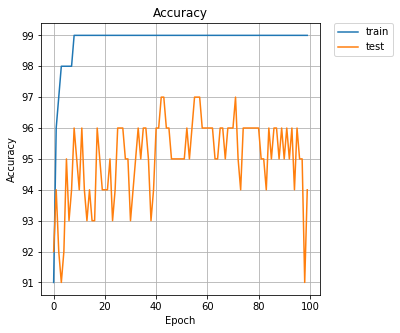

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5, 5))
plt.plot(range(len(train_m)), train_m, label="train")
plt.plot(range(len(test_m)), test_m, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.title('Accuracy')